In [1]:
import addfips
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import folium
import pickle
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import pyproj

%matplotlib inline

## Shapefile

In [2]:
# Bring in the TIGER file:
counties = gpd.read_file('../data/tn_counties/tncounty.shp')
print(counties.crs)
counties.head()

epsg:2274


,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774...."
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ..."
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ..."


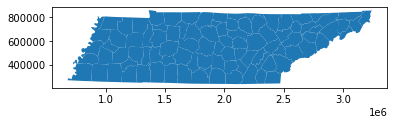

In [3]:
counties.plot();

In [4]:
counties.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Tennessee
- bounds: (-90.31, 34.98, -81.65, 36.68)
Coordinate Operation:
- name: SPCS83 Tennessee zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Bring in the file to join:

In [5]:
crisis = pd.read_csv('../data/Crisis.csv', encoding="ISO-8859-1")
crisis.head(2)

C:\Users\zzach\anaconda3\envs\geospatial\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,CallReportNum,CallDateAndTimeStart,CallDateAndTimeEnd,CallLength,CallerNum,PhoneWorkerNum,CityName,CountyName,StateProvince,...,Suicide History/Previous Attempts,Grief due to Suicide Loss,Information about SOSL support group,Third party concerned about anothers suicide risk,CURRENT THOUGHTS/IDEATIONS,Total Suicide Issues,Total Number of Issues,IR Call,IR_CallTag,Number of Imminent Risk Issues
0,0,82699332,12/31/2020 23:40,12/31/2020 23:53,13,3769693,116928,Houston,Harris,TX,...,0,0,0,0,0,0,4,No,0,0
1,1,82689642,12/31/2020 22:31,12/31/2020 23:00,29,-1,136748,NaN,NaN,TN,...,0,0,0,0,0,0,2,No,0,0


##### Cut out TN:

In [6]:
tn_crisis = crisis.loc[crisis['StateProvince'] == 'TN']

### Bring in population density csv to join

In [7]:
pop = pd.read_csv('../data/TN_popdensity.csv')
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   County                     95 non-null     object 
 1   Total Population per acre  95 non-null     float64
 2   Total Population           95 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
pop = pop.rename(columns = {'Total Population per acre': 'PopDensity'})

In [9]:
pop.PopDensity.astype(int)

0     1
1     0
2     0
3     0
4     0
     ..
90    0
91    0
92    0
93    0
94    0
Name: PopDensity, Length: 95, dtype: int32

### Merge them:

In [10]:
tennessee = pd.merge(left = counties, right = tn_crisis,
                    left_on = 'NAME', right_on = 'CountyName')
tennessee.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,Unnamed: 0,CallReportNum,CallDateAndTimeStart,CallDateAndTimeEnd,...,Suicide History/Previous Attempts,Grief due to Suicide Loss,Information about SOSL support group,Third party concerned about anothers suicide risk,CURRENT THOUGHTS/IDEATIONS,Total Suicide Issues,Total Number of Issues,IR Call,IR_CallTag,Number of Imminent Risk Issues
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",336,82501983,12/26/2020 16:45,12/26/2020 16:50,...,0,0,0,0,0,0,1,No,0,0
1,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",361,82490756,12/26/2020 8:20,12/26/2020 8:32,...,0,0,0,0,0,0,6,No,0,0
2,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",495,82430024,12/23/2020 17:43,12/23/2020 17:47,...,0,0,0,0,0,0,6,No,0,0
3,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",554,82396951,12/22/2020 21:19,12/22/2020 21:29,...,0,0,0,0,0,0,5,No,0,0
4,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",826,82256940,12/18/2020 18:07,12/18/2020 18:11,...,0,0,0,0,0,0,6,No,0,0


In [11]:
tn_w_pop = pd.merge(left = tennessee, right = pop,
                    left_on = 'NAME', right_on = 'County')
tn_w_pop.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,Unnamed: 0,CallReportNum,CallDateAndTimeStart,CallDateAndTimeEnd,...,Third party concerned about anothers suicide risk,CURRENT THOUGHTS/IDEATIONS,Total Suicide Issues,Total Number of Issues,IR Call,IR_CallTag,Number of Imminent Risk Issues,County,PopDensity,Total Population
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",336,82501983,12/26/2020 16:45,12/26/2020 16:50,...,0,0,0,1,No,0,0,Chester,0.093928,17190
1,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",361,82490756,12/26/2020 8:20,12/26/2020 8:32,...,0,0,0,6,No,0,0,Chester,0.093928,17190
2,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",495,82430024,12/23/2020 17:43,12/23/2020 17:47,...,0,0,0,6,No,0,0,Chester,0.093928,17190
3,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",554,82396951,12/22/2020 21:19,12/22/2020 21:29,...,0,0,0,5,No,0,0,Chester,0.093928,17190
4,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",826,82256940,12/18/2020 18:07,12/18/2020 18:11,...,0,0,0,6,No,0,0,Chester,0.093928,17190


In [12]:
tn_w_pop['nothing'] = 1

In [37]:
tn_just_pop_geo = tn_w_pop[['NAME', 'geometry', 'PopDensity', 'Total Population', 'Total Number of Issues', 'Number of Imminent Risk Issues', 'IR_CallTag', 'nothing']]

In [38]:
tn_just_pop_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9229 entries, 0 to 9228
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   NAME                            9229 non-null   object  
 1   geometry                        9229 non-null   geometry
 2   PopDensity                      9229 non-null   float64 
 3   Total Population                9229 non-null   int64   
 4   Total Number of Issues          9229 non-null   int64   
 5   Number of Imminent Risk Issues  9229 non-null   int64   
 6   IR_CallTag                      9229 non-null   int64   
 7   nothing                         9229 non-null   int64   
dtypes: float64(1), geometry(1), int64(5), object(1)
memory usage: 648.9+ KB


In [15]:
tennessee.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9229 entries, 0 to 9228
Columns: 242 entries, OBJECTID to Number of Imminent Risk Issues
dtypes: float64(3), geometry(1), int64(208), object(30)
memory usage: 17.1+ MB


##### First see what counties blip with the total number of issues and imminent risk issues in 2020 calls:

In [16]:
#im_risk_totals = tn_just_pop_geo.groupby(['NAME'])['Number of Imminent Risk Issues'].apply(lambda x: x.astype(int).sum())

In [17]:
im_risk_totals = tn_just_pop_geo.groupby(['NAME']).agg({'Number of Imminent Risk Issues': 'sum', 'Total Population': 'max'})

In [18]:
im_risk_totals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, Anderson to Wilson
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Number of Imminent Risk Issues  75 non-null     int64
 1   Total Population                75 non-null     int64
dtypes: int64(2)
memory usage: 1.8+ KB


In [19]:
im_risk_totals['normalized'] = im_risk_totals['Number of Imminent Risk Issues']/im_risk_totals['Total Population']

In [20]:
imrisk_wgeo = pd.merge(left = counties, right = im_risk_totals,
                     left_on = 'NAME', right_on = 'NAME')
imrisk_wgeo.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,Number of Imminent Risk Issues,Total Population,normalized
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",5,17190,0.000291
1,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ...",11,360919,0.000030
2,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ...",0,13427,0.000000
3,81,Robertson,47147,1.328462e+10,562663.703799,"POLYGON ((1638980.637 774369.872, 1639040.173 ...",4,70280,0.000057
4,82,Sumner,47165,1.514543e+10,648398.742792,"POLYGON ((1746373.100 755132.541, 1746686.022 ...",16,183437,0.000087


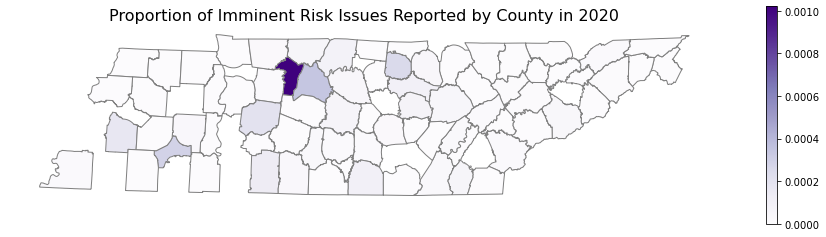

In [21]:
fig, ax = plt.subplots(figsize=(16,4))
imrisk_wgeo.plot(column = 'normalized',
               cmap = 'Purples',
               edgecolor = 'grey',
                legend = True,
              ax = ax)
plt.title('Proportion of Imminent Risk Issues Reported by County in 2020', fontsize = 16)
ax.axis('off');

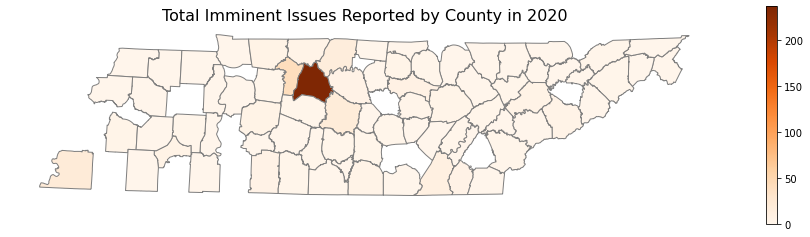

In [22]:
fig, ax = plt.subplots(figsize=(16,4))
imrisk_wgeo.plot(column = 'Number of Imminent Risk Issues',
               cmap = 'Oranges',
               edgecolor = 'grey',
               legend = True,
              ax = ax)
plt.title('Total Imminent Issues Reported by County in 2020', fontsize = 16)
ax.axis('off');

In [23]:
#issues_totals = tennessee.groupby(['NAME'])['Total Number of Issues'].apply(lambda x: x.astype(int).sum())
issues_totals = tn_just_pop_geo.groupby(['NAME']).agg({'Total Number of Issues': 'sum', 'Total Population': 'max'})

In [24]:
issues_totals['normalized'] = issues_totals['Total Number of Issues']/issues_totals['Total Population']

In [25]:
issues_wgeo = pd.merge(left = counties, right = issues_totals,
                     left_on = 'NAME', right_on = 'NAME')
issues_wgeo.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,Total Number of Issues,Total Population,normalized
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",1291,17190,0.075102
1,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ...",1445,360919,0.004004
2,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ...",9,13427,0.000670
3,81,Robertson,47147,1.328462e+10,562663.703799,"POLYGON ((1638980.637 774369.872, 1639040.173 ...",1263,70280,0.017971
4,82,Sumner,47165,1.514543e+10,648398.742792,"POLYGON ((1746373.100 755132.541, 1746686.022 ...",2450,183437,0.013356


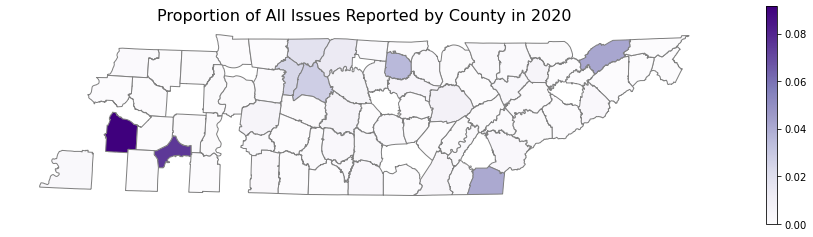

In [26]:
fig, ax = plt.subplots(figsize=(16,4))
issues_wgeo.plot(column = 'normalized',
               cmap = 'Purples',
               edgecolor = 'grey',
                legend = True,
              ax = ax)
plt.title('Proportion of All Issues Reported by County in 2020', fontsize = 16)
ax.axis('off');

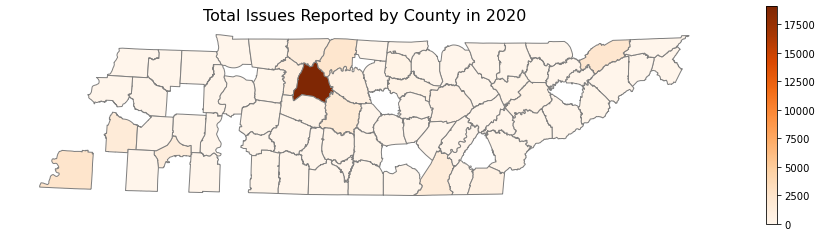

In [27]:
fig, ax = plt.subplots(figsize=(16,4))
issues_wgeo.plot(column = 'Total Number of Issues',
               cmap = 'Oranges',
               edgecolor = 'grey',
               legend = True,
              ax = ax)
plt.title('Total Issues Reported by County in 2020', fontsize = 16)
ax.axis('off');

### Do total IR calls by county

In [40]:
county_IRtotals = tn_just_pop_geo.groupby(['NAME']).agg({'IR_CallTag': 'sum', 'Total Population': 'max'})

In [41]:
county_IRtotals['normalized'] = county_IRtotals['IR_CallTag']/county_IRtotals['Total Population']

In [42]:
county_IRtotals

,IR_CallTag,Total Population,normalized
NAME,,,
Anderson,1,76061,0.000013
Bedford,1,48292,0.000021
Benton,0,16140,0.000000
Bledsoe,0,14836,0.000000
Blount,0,129927,0.000000
...,...,...,...
Washington,0,127805,0.000000
Weakley,0,33510,0.000000
White,2,26800,0.000075


In [43]:
IRw_geometry = pd.merge(left = counties, right = county_IRtotals,
                     left_on = 'NAME', right_on = 'NAME')
IRw_geometry.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,IR_CallTag,Total Population,normalized
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",4,17190,0.000233
1,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ...",11,360919,0.000030
2,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ...",0,13427,0.000000
3,81,Robertson,47147,1.328462e+10,562663.703799,"POLYGON ((1638980.637 774369.872, 1639040.173 ...",2,70280,0.000028
4,82,Sumner,47165,1.514543e+10,648398.742792,"POLYGON ((1746373.100 755132.541, 1746686.022 ...",15,183437,0.000082


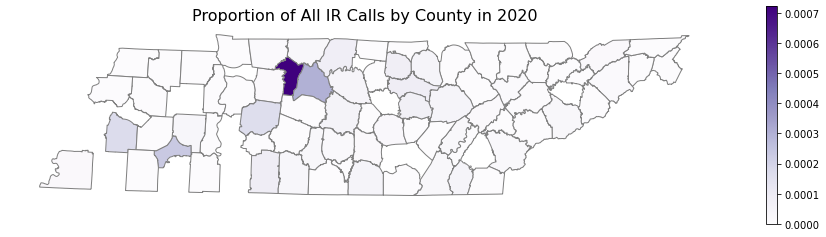

In [44]:
fig, ax = plt.subplots(figsize=(16,4))
IRw_geometry.plot(column = 'normalized',
               cmap = 'Purples',
               edgecolor = 'grey',
                legend = True,
              ax = ax)
plt.title('Proportion of All IR Calls by County in 2020', fontsize = 16)
ax.axis('off');

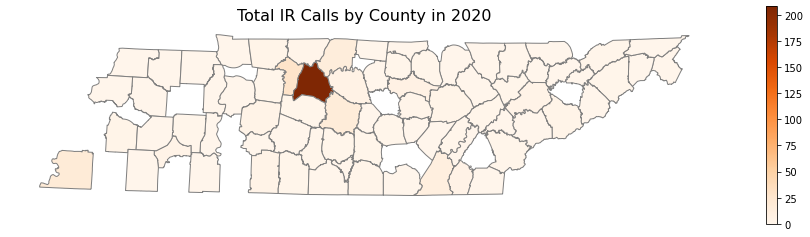

In [46]:
fig, ax = plt.subplots(figsize=(16,4))
IRw_geometry.plot(column = 'IR_CallTag',
               cmap = 'Oranges',
               edgecolor = 'grey',
                legend = True,
              ax = ax)
plt.title('Total IR Calls by County in 2020', fontsize = 16)
ax.axis('off');

### Make a new column of ones and group total calls by county

In [28]:
#tennessee['nothing'] = 1
tn_just_pop_geo['nothing'] = 1

C:\Users\zzach\anaconda3\envs\geospatial\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [29]:
#county_totals = tennessee.groupby(['NAME'])['nothing'].apply(lambda x: x.astype(int).sum())
county_totals = tn_just_pop_geo.groupby(['NAME']).agg({'nothing': 'sum', 'Total Population': 'max'})

In [30]:
county_totals['normalized'] = county_totals['nothing']/county_totals['Total Population']

In [31]:
county_totals 

,nothing,Total Population,normalized
NAME,,,
Anderson,57,76061,0.000749
Bedford,25,48292,0.000518
Benton,3,16140,0.000186
Bledsoe,1,14836,0.000067
Blount,19,129927,0.000146
...,...,...,...
Washington,4,127805,0.000031
Weakley,3,33510,0.000090
White,3,26800,0.000112


In [32]:
w_geometry = pd.merge(left = counties, right = county_totals,
                     left_on = 'NAME', right_on = 'NAME')
w_geometry.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry,nothing,Total Population,normalized
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ...",222,17190,0.012914
1,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ...",324,360919,0.000898
2,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ...",1,13427,0.000074
3,81,Robertson,47147,1.328462e+10,562663.703799,"POLYGON ((1638980.637 774369.872, 1639040.173 ...",320,70280,0.004553
4,82,Sumner,47165,1.514543e+10,648398.742792,"POLYGON ((1746373.100 755132.541, 1746686.022 ...",686,183437,0.003740


In [33]:
type(w_geometry)

geopandas.geodataframe.GeoDataFrame

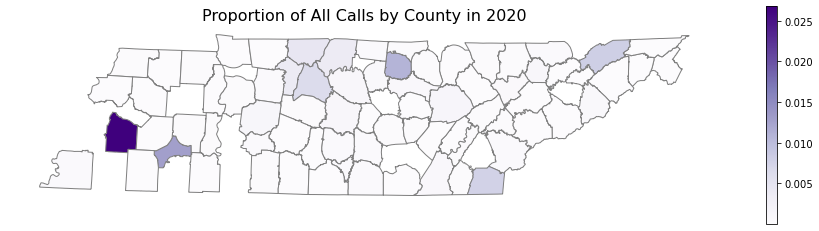

In [34]:
fig, ax = plt.subplots(figsize=(16,4))
w_geometry.plot(column = 'normalized',
               cmap = 'Purples',
               edgecolor = 'grey',
                legend = True,
              ax = ax)
plt.title('Proportion of All Calls by County in 2020', fontsize = 16)
ax.axis('off');

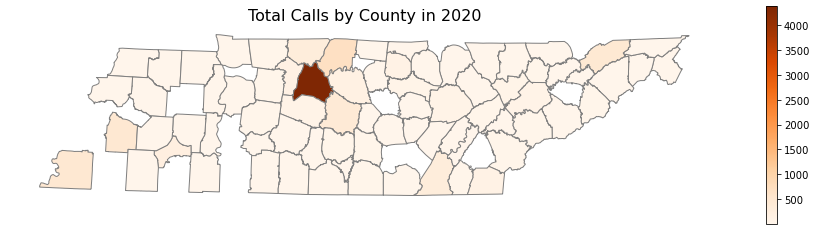

In [35]:
fig, ax = plt.subplots(figsize=(16,4))
w_geometry.plot(column = 'nothing',
               cmap = 'Oranges',
               edgecolor = 'grey',
                legend = True,
              ax = ax)
plt.title('Total Calls by County in 2020', fontsize = 16)
ax.axis('off');

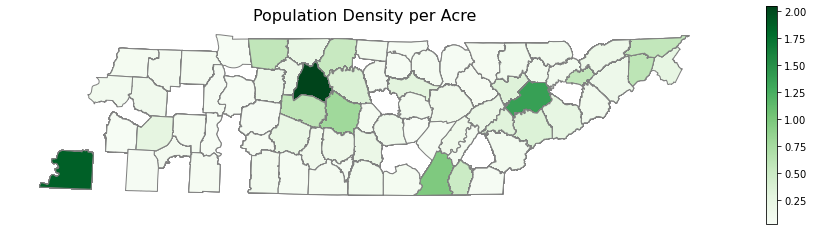

In [36]:
fig, ax = plt.subplots(figsize=(16,4))
tn_w_pop.plot(column = 'PopDensity',
               cmap = 'Greens',
               edgecolor = 'grey',
              legend = True,
              ax = ax)
plt.title('Population Density per Acre', fontsize = 16)
ax.axis('off');